# Import library

In [1]:
import sys
sys.path.append('src')
import enex_analysis as enex
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dartwork_mpl as dm
import warnings
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")
dm.use_style('dmpl_light')
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "custom",
    "mathtext.rm": "Roboto",
    "mathtext.it": "Roboto:italic",
    "mathtext.bf": "Roboto:bold",
    "mathtext.sf": "Roboto",
    "mathtext.tt": "DejaVu Sans Mono",
    "mathtext.fallback": "stix",
    "mathtext.default": "it",
})

Load colors...
Load colormaps...


# Figure function

In [2]:
def fs_dict_update(fs):
    plt.rcParams['font.size'] = fs

    fs_dict = {
        'label': dm.fs(0),
        'tick': dm.fs(-1),
        'ctick': dm.fs(-2),
        'legend': dm.fs(-1.5),
        'annotation': dm.fs(-1),
                }
    return fs_dict

pad = {
    'label': 6,
    'tick': 4,
}

layout ={
    'bbox': (0.1, 0.1, 0.8, 0.8),
    'margins': (0, 0, 0, 0),
}

LW = np.arange(0.25, 3.0, 0.25)

# Simulation

In [11]:
#%% 시뮬레이션 및 결과 시각화
'''
24시간 운전 시나리오
가상 시나리오는 다음과 같이 설정

초기 상태: 탱크의 모든 노드는 40°C로 균일하게 시작합니다.
외기 온도: 하루 동안 15°C에서 25°C 사이를 부드럽게 변동합니다.
온수 사용: 아침(7-9시)과 저녁(19-21시)에 집중적으로 온수를 사용합니다.
내부 히터: 탱크 하부(Node 10)에 히터가 설치되어 있으며, 이 노드의 온도가 50°C 아래로 떨어지면 작동하고 60°C 이상으로 올라가면 멈추는 자동온도조절기(Thermostat) 로직을 따릅니다.
급수 온도: 탱크로 유입되는 물의 온도는 15°C로 일정합니다.
'''

# --- 1. 시뮬레이션 설정 ---
H = 0.8; D = 0.4; N = 10 # --> 약 100 L 탱크
tank = enex.StratifiedTankTDMA(r0=0.25, x_shell=0.005, x_ins=0.05, k_shell=50, k_ins=0.04, H=H, N=N, h_w=10, h_o=5)

T_initial_C = 40.0 # 초기 탱크 온도 [°C]
T_in_C = 15.0 # 유입수 온도 [°C]

heater_power_W = 3000 # 히터 전력 [W]
heater_node = 10 # 히터 위치

thermostat_on_C = 50.0 # 서모스탯 켜짐 온도 [°C]
thermostat_off_C = 60.0 # 서모스탯 꺼짐 온도 [°C]

dt = 5 # 시간 간격 (60초 = 1분)
sim_hours = 24
n_steps = int(sim_hours * enex.h2s / dt)
t_span = np.arange(n_steps) * dt # 시간 배열 [초]

# --- 2. 24시간 가상 스케줄 생성 ---
# 외기 온도 스케줄 (15°C ~ 25°C 사이에서 변동)
T_amb_C = 20 - 5 * np.cos(2 * np.pi * t_span / (24 * enex.h2s))
T_amb_K = enex.C2K(T_amb_C)

# 온수 사용량(dV) 스케줄 [m³/s]
# 아침(7-9시), 저녁(19-21시)에 각 100리터 사용 가정
dV_schedule = np.zeros(n_steps)
morning_usage_L = 100
evening_usage_L = 100
morning_start_idx = int(7 * enex.h2s / dt)
morning_end_idx = int(8 * enex.h2s / dt)
evening_start_idx = int(19 * enex.h2s / dt)
evening_end_idx = int(20 * enex.h2s / dt)

# 사용 시간에 걸쳐 유량 균등 분배
dV_schedule[morning_start_idx:morning_end_idx] = (morning_usage_L * enex.L2m3) / (morning_end_idx - morning_start_idx) / dt # 단위: m³/s
dV_schedule[evening_start_idx:evening_end_idx] = (evening_usage_L * enex.L2m3) / (evening_end_idx - evening_start_idx) / dt # 단위: m³/s

# --- 3. 시뮬레이션 실행 ---
# 결과 저장을 위한 배열 초기화
T_results = np.zeros((n_steps, N))
T_now = np.full(N, enex.C2K(T_initial_C)) # 초기 온도를 Kelvin으로 설정

# 메인 시뮬레이션 루프
for i in range(n_steps):
    # 서모스탯 로직에 따라 히터 전원 결정
    heater_on = False
    heater_sensor_temp_C = enex.K2C(T_now[heater_node-1])
    if heater_sensor_temp_C < thermostat_on_C:
        heater_on = True
    elif heater_sensor_temp_C > thermostat_off_C:
        heater_on = False
    
    enexrrent_heater_W = heater_power_W if heater_on else 0.0

    # 현재 상태로 다음 시간 단계의 온도 계산
    T_next = tank.step(
        T=T_now,
        dt=dt,
        T_in=enex.C2K(T_in_C),
        dV=dV_schedule[i],
        T_amb=T_amb_K[i],
        Q_heater_node=heater_node,
        Q_heater_W=enexrrent_heater_W
    )
    
    # 결과 저장 및 상태 업데이트
    T_results[i, :] = T_next
    T_now = T_next

# Visualization

In [12]:
fs_dict = fs_dict_update(9)
# --- 4. 결과 시각화 ---
fig, ax = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(7)))

xmin1, xmax1, xint1, xmar1 = 0, sim_hours, 2, 0
ymin1, ymax1, yint1, ymar1 = 10, 60, 10, 0
ymin2, ymax2, yint2, ymar2 = 0, 2, 0.5, 0

t_hours = t_span * enex.s2h
T_results_C = enex.K2C(T_results)

color_ax2 = 'dm.red'
cmap = plt.get_cmap('dm.Blues9_r')
colors = [cmap(i) for i in np.linspace(0.1, 0.9, N)]


# 각 노드(성층)별 온도 변화 플로팅
for i in range(N):
    # 최상단(Node 1)은 굵게, 최하단(Node 10)은 점선으로 표시
    if i == 0:
        ax.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$' + '(Top)', linewidth= LW[3], color=colors[i])
    elif i == N - 1:
        ax.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$' + '(Bottom)', linewidth= LW[3], color=colors[i])
    else:
        ax.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$', linewidth =LW[3], color=colors[i])

# 5) plot detail
ax.set_xlabel('Elapsed Time [Hours]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax.set_ylabel('Temperature [°C]', fontsize=fs_dict['label'], labelpad=pad['label'])

ax.set_xlim(xmin1 - xmar1, xmax1 + xmar1)
ax.set_ylim(ymin1 - ymar1, ymax1 + ymar1)

# ax.annotate(annotations, xy=(.01, 1.01), xycoords='axes fraction',
#     horizontalalignment='left', verticalalignment='bottom', fontsize=fs_dict['annotation']) 

ax.set_xticks(np.arange(xmin1, xmax1*1.001, xint1))
ax.set_yticks(np.arange(ymin1, ymax1*1.001, yint1))

ax.tick_params(labelsize=fs_dict['tick'], which='major', length=2.5, width=0.3  , pad=pad['tick'])
ax.tick_params(labelsize=fs_dict['tick'], which='minor', length=1.25, width=0.3, pad=pad['tick'])

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(1))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc = 'upper center',fontsize=fs_dict['legend'], bbox_to_anchor=(0.5, 1.1), ncols=5,
          handlelength = 1.5, columnspacing=2, labelspacing=0.5)


# 그래프 설정
ax.set_xlabel('Elapsed Time [Hours]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax.set_ylabel('Temperature [°C]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax.set_xticks(np.arange(0, 25, 2))

# 온수 사용 시점 시각적으로 표시
ax2 = ax.twinx()
ax2.fill_between(t_hours, 0, dV_schedule * enex.m32L / enex.s2m, color=color_ax2 + '4', alpha=0.3, label='Hot water use [L/min]')
ax2.set_ylabel('Hot Water Usage [L/min]', fontsize=fs_dict['label'], labelpad=pad['label'], color=color_ax2 + '6')

ax2.set_ylim(0, ymax2)

ax2.set_yticks(np.arange(ymin2, ymax2*1.001, yint2))
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color(color_ax2 + '6')
ax2.tick_params(axis='y', colors=color_ax2 + '6', labelsize=fs_dict['tick'], which='major', pad=pad['tick'])

dm.simple_layout(fig, bbox=[0, 1, 0, 1], margins=[0.05, 0.05, 0.05, 0.05])
plt.savefig('figure/Tank_stratification_model/Tank_stratification_model_results(Bottom heater).png', dpi=300)
dm.save_and_show(fig)

<Figure size 1050x900 with 0 Axes>

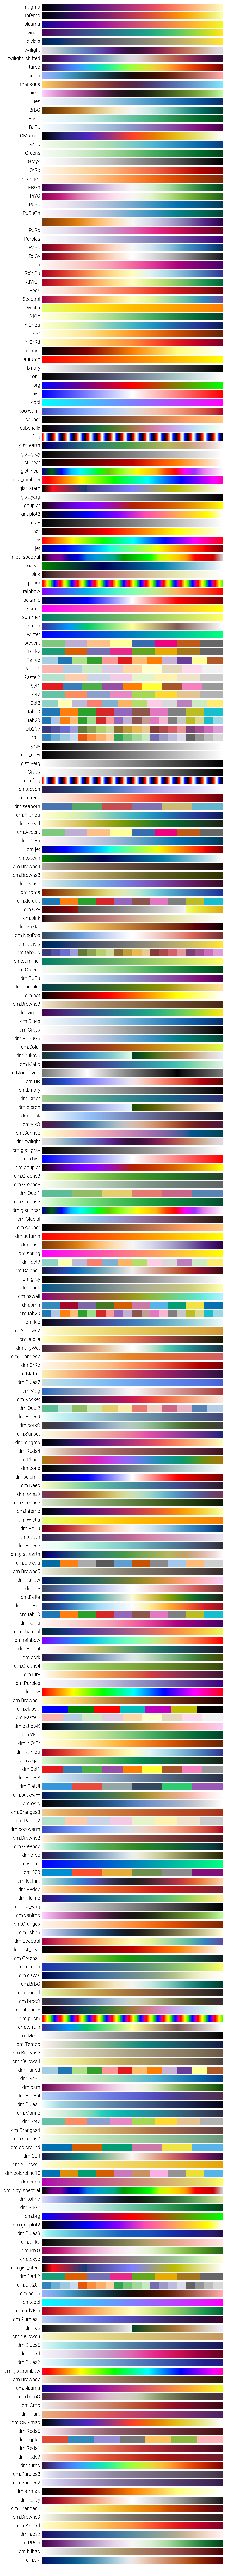

In [6]:
dm.plot_colormaps()
plt.show()